In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!unzip /content/drive/MyDrive/"사물 이미지 분류"/data.zip -d /content/drive/MyDrive/"사물 이미지 분류"

In [3]:
import tensorflow as tf 
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [4]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [10]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images
        label = filename.split('/')[2] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [11]:
#create test dataset

path = './test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    label = filename.split('/')[2] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


[9],[9],[0],[0],[8],[8],[6],[6],[7],[7],[3],[3],[2],[2],[4],[4],[1],[1],[5],[5],

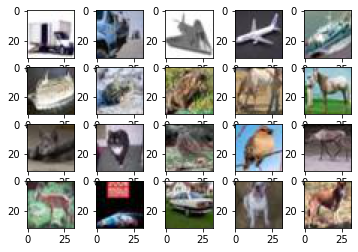

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(training_images[i*2500])
    print(training_labels[i*2500], end=",")
plt.show()

In [13]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
    print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    brightness_range = [0.9, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

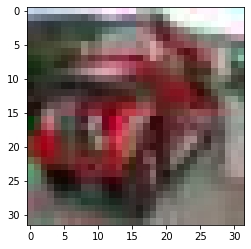

In [15]:
sample_image = training_images[1]
plt.imshow(sample_image.astype('uint8'))
sample_image = np.expand_dims(sample_image, 0)

In [16]:
sample_image_it = image_generator.flow(sample_image, batch_size=1)

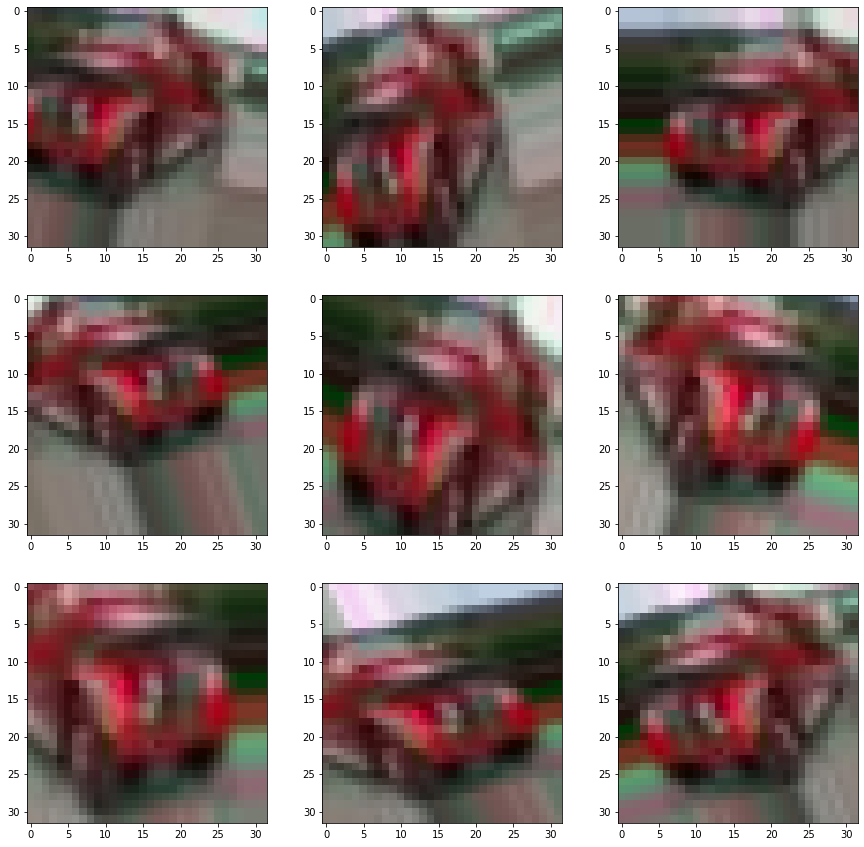

In [17]:
fig = plt.figure(figsize = (15,15))
for i in range(9):
    plt.subplot(3, 3, 1+i)
    batch = sample_image_it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [18]:
augment_size=100000

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

In [19]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

training_images = np.concatenate((training_images, training_image_aug))
training_labels = np.concatenate((training_labels, training_labels_aug))

In [20]:
print(training_images.shape)
print(training_labels.shape)

(150000, 32, 32, 3)
(150000, 1)


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, stratify = training_labels, random_state=42)

X_test = test_images

In [22]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (120000, 32, 32, 3)
X_valid 크기: (30000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


In [23]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

In [24]:
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer
    #tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [25]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [27]:
data = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=64)

Epoch 1/25
1875/1875 [==============================] - 120s 58ms/step - loss: 1.4786 - accuracy: 0.4792 - val_loss: 1.1818 - val_accuracy: 0.5979
Epoch 2/25
1875/1875 [==============================] - 108s 58ms/step - loss: 0.9724 - accuracy: 0.6753 - val_loss: 1.1380 - val_accuracy: 0.6244
Epoch 3/25
1875/1875 [==============================] - 111s 59ms/step - loss: 0.7478 - accuracy: 0.7531 - val_loss: 0.7542 - val_accuracy: 0.7438
Epoch 4/25
1875/1875 [==============================] - 108s 58ms/step - loss: 0.5957 - accuracy: 0.8022 - val_loss: 0.6832 - val_accuracy: 0.7764
Epoch 5/25
1875/1875 [==============================] - 111s 59ms/step - loss: 0.4721 - accuracy: 0.8425 - val_loss: 0.6416 - val_accuracy: 0.7990
Epoch 6/25
1875/1875 [==============================] - 111s 59ms/step - loss: 0.3609 - accuracy: 0.8802 - val_loss: 0.6700 - val_accuracy: 0.7933
Epoch 7/25
1875/1875 [==============================] - 111s 59ms/step - loss: 0.2827 - accuracy: 0.9054 - val_loss: 0

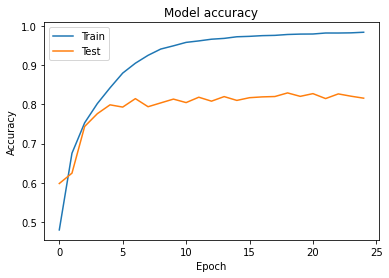

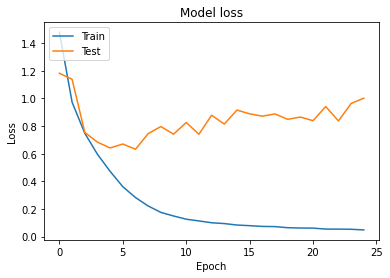

In [29]:
import matplotlib.pyplot as plot

plot.plot(data.history['accuracy'])
plot.plot(data.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(data.history['loss'])
plot.plot(data.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [30]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'horse', 'airplane'], dtype='<U10')

In [32]:
import pandas as pd

submission = pd.read_csv('/content/sample_submission.csv')

In [33]:
submission['target'] = pred_class
submission.to_csv('CNN.csv', index = False)

In [43]:
submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,airplane
